In [1]:
from dask.distributed import Client

client = Client("YOUR_CLIENT")
client

<Client: 'tls://192.168.144.139:8786' processes=2 threads=4, memory=12.72 GiB>

In [2]:
import yaml
import numpy as np
from collections import defaultdict

import awkward as ak
import uproot
import coffea
import coffea.processor as processor
from coffea import hist

from coffea.nanoevents import NanoEventsFactory
from coffea.nanoevents import NanoAODSchema

import matplotlib.pyplot as plt

In [3]:
year = '2017'


with open("HLT_Run2_UL.yaml", 'r') as f_yml:
    dict_HLT = yaml.load(f_yml, Loader=yaml.FullLoader)

hlt_ls = [_hlt.split('HLT_')[-1] for _hlt_ls in dict_HLT[year].values() for _hlt in _hlt_ls]

with open(f'{year}_MC.txt') as f_tt:
    lines = f_tt.read().splitlines()

fileset_TT = [''.join(['root://xcache/', line]) for line in lines]

with open(f'{year}_data.txt') as f_tt:
    lines = f_tt.read().splitlines()

fileset_MET = [''.join(['root://xcache/', line]) for line in lines]

fileset_MC_Data = {'TT': fileset_TT, 'data_MET': fileset_MET}
# fileset_MC_Data = {'TT': fileset_TT[:3], 'data_MET': fileset_MET[:3]}

In [5]:
class Trig_Processor(processor.ProcessorABC):
    def __init__(self, isMC, hlts_lep, era=2018):
        self.isMC = isMC
        self.era = era
        self.hlts_lep = hlts_lep
        self.hlts_met = ['PFMET100_PFMHT100_IDTight_PFHT60',
                         'PFMET110_PFMHT110_IDTight',
                         'PFMET120_PFMHT120_IDTight',
                         'PFMET120_PFMHT120_IDTight_PFHT60',
                         'PFMET130_PFMHT130_IDTight',
                         'PFMET140_PFMHT140_IDTight',
                         'PFMET200_HBHECleaned',
                         'PFMET200_HBHE_BeamHaloCleaned',
                         'PFMET200_NotCleaned',
                         'PFMET250_HBHECleaned',
                         'PFMET300_HBHECleaned',
                         'PFMETNoMu100_PFMHTNoMu100_IDTight_PFHT60',
                         'PFMETNoMu110_PFMHTNoMu110_IDTight',
                         'PFMETNoMu120_PFMHTNoMu120_IDTight',
                         'PFMETNoMu120_PFMHTNoMu120_IDTight_PFHT60',
                         'PFMETNoMu130_PFMHTNoMu130_IDTight',
                         'PFMETNoMu140_PFMHTNoMu140_IDTight',
                         'PFMETTypeOne100_PFMHT100_IDTight_PFHT60',
                         'PFMETTypeOne110_PFMHT110_IDTight',
                         'PFMETTypeOne120_PFMHT120_IDTight',
                         'PFMETTypeOne120_PFMHT120_IDTight_PFHT60',
                         'PFMETTypeOne130_PFMHT130_IDTight',
                         'PFMETTypeOne140_PFMHT140_IDTight',
                         'PFMETTypeOne200_HBHE_BeamHaloCleaned']
        
        dataset_axis = hist.Cat("dataset", "")
        bins = [20, 25, 30, 35, 40, 50, 60, 70]
        lead_axis = hist.Bin("lead", "pT lead [GeV]", bins)
        trail_axis = hist.Bin("trail", "pT trail [GeV]", bins)
        
        self._accumulator = processor.dict_accumulator({
            'h_num_MM_EE': hist.Hist('num_MM_EE', dataset_axis, lead_axis, trail_axis),
            'h_num_ME_EE': hist.Hist('num_ME_EE', dataset_axis, lead_axis, trail_axis),
            'h_num_EM_EE': hist.Hist('num_EM_EE', dataset_axis, lead_axis, trail_axis),
            'h_num_EE_EE': hist.Hist('num_EE_EE', dataset_axis, lead_axis, trail_axis),
            'h_den_MM_EE': hist.Hist('den_MM_EE', dataset_axis, lead_axis, trail_axis),
            'h_den_ME_EE': hist.Hist('den_ME_EE', dataset_axis, lead_axis, trail_axis),
            'h_den_EM_EE': hist.Hist('den_EM_EE', dataset_axis, lead_axis, trail_axis),
            'h_den_EE_EE': hist.Hist('den_EE_EE', dataset_axis, lead_axis, trail_axis),

            'h_num_MM_EB': hist.Hist('num_MM_EB', dataset_axis, lead_axis, trail_axis),
            'h_num_ME_EB': hist.Hist('num_ME_EB', dataset_axis, lead_axis, trail_axis),
            'h_num_EM_EB': hist.Hist('num_EM_EB', dataset_axis, lead_axis, trail_axis),
            'h_num_EE_EB': hist.Hist('num_EE_EB', dataset_axis, lead_axis, trail_axis),
            'h_den_MM_EB': hist.Hist('den_MM_EB', dataset_axis, lead_axis, trail_axis),
            'h_den_ME_EB': hist.Hist('den_ME_EB', dataset_axis, lead_axis, trail_axis),
            'h_den_EM_EB': hist.Hist('den_EM_EB', dataset_axis, lead_axis, trail_axis),
            'h_den_EE_EB': hist.Hist('den_EE_EB', dataset_axis, lead_axis, trail_axis),

            'h_num_MM_BE': hist.Hist('num_MM_BE', dataset_axis, lead_axis, trail_axis),
            'h_num_ME_BE': hist.Hist('num_ME_BE', dataset_axis, lead_axis, trail_axis),
            'h_num_EM_BE': hist.Hist('num_EM_BE', dataset_axis, lead_axis, trail_axis),
            'h_num_EE_BE': hist.Hist('num_EE_BE', dataset_axis, lead_axis, trail_axis),
            'h_den_MM_BE': hist.Hist('den_MM_BE', dataset_axis, lead_axis, trail_axis),
            'h_den_ME_BE': hist.Hist('den_ME_BE', dataset_axis, lead_axis, trail_axis),
            'h_den_EM_BE': hist.Hist('den_EM_BE', dataset_axis, lead_axis, trail_axis),
            'h_den_EE_BE': hist.Hist('den_EE_BE', dataset_axis, lead_axis, trail_axis),

            'h_num_MM_BB': hist.Hist('num_MM_BB', dataset_axis, lead_axis, trail_axis),
            'h_num_ME_BB': hist.Hist('num_ME_BB', dataset_axis, lead_axis, trail_axis),
            'h_num_EM_BB': hist.Hist('num_EM_BB', dataset_axis, lead_axis, trail_axis),
            'h_num_EE_BB': hist.Hist('num_EE_BB', dataset_axis, lead_axis, trail_axis),
            'h_den_MM_BB': hist.Hist('den_MM_BB', dataset_axis, lead_axis, trail_axis),
            'h_den_ME_BB': hist.Hist('den_ME_BB', dataset_axis, lead_axis, trail_axis),
            'h_den_EM_BB': hist.Hist('den_EM_BB', dataset_axis, lead_axis, trail_axis),
            'h_den_EE_BB': hist.Hist('den_EE_BB', dataset_axis, lead_axis, trail_axis),
        })

    
    @property
    def accumulator(self):
        return self._accumulator

    
    def process(self, events):
        output = self.accumulator.identity()
        
        dataset = events.metadata["dataset"]
        
        # HLT
        hlt_avail = events.HLT.layout.keys()
        events_MET = self.HLT_MET(events, hlt_avail)
        events_LEP = self.HLT_LEP(events_MET, hlt_avail)
        
        # pt arrays
        dic_pt_MET = self.get_pTs_from_events(events_MET)
        dic_pt_LEP = self.get_pTs_from_events(events_LEP)

        output['h_num_MM_EE'].fill(dataset=dataset, lead=dic_pt_LEP['pt_lead_MM_EE'], trail=dic_pt_LEP['pt_trail_MM_EE'])
        output['h_num_ME_EE'].fill(dataset=dataset, lead=dic_pt_LEP['pt_lead_ME_EE'], trail=dic_pt_LEP['pt_trail_ME_EE'])
        output['h_num_EM_EE'].fill(dataset=dataset, lead=dic_pt_LEP['pt_lead_EM_EE'], trail=dic_pt_LEP['pt_trail_EM_EE'])
        output['h_num_EE_EE'].fill(dataset=dataset, lead=dic_pt_LEP['pt_lead_EE_EE'], trail=dic_pt_LEP['pt_trail_EE_EE'])

        output['h_den_MM_EE'].fill(dataset=dataset, lead=dic_pt_MET['pt_lead_MM_EE'], trail=dic_pt_MET['pt_trail_MM_EE'])
        output['h_den_ME_EE'].fill(dataset=dataset, lead=dic_pt_MET['pt_lead_ME_EE'], trail=dic_pt_MET['pt_trail_ME_EE'])
        output['h_den_EM_EE'].fill(dataset=dataset, lead=dic_pt_MET['pt_lead_EM_EE'], trail=dic_pt_MET['pt_trail_EM_EE'])
        output['h_den_EE_EE'].fill(dataset=dataset, lead=dic_pt_MET['pt_lead_EE_EE'], trail=dic_pt_MET['pt_trail_EE_EE'])

        output['h_num_MM_EB'].fill(dataset=dataset, lead=dic_pt_LEP['pt_lead_MM_EB'], trail=dic_pt_LEP['pt_trail_MM_EB'])
        output['h_num_ME_EB'].fill(dataset=dataset, lead=dic_pt_LEP['pt_lead_ME_EB'], trail=dic_pt_LEP['pt_trail_ME_EB'])
        output['h_num_EM_EB'].fill(dataset=dataset, lead=dic_pt_LEP['pt_lead_EM_EB'], trail=dic_pt_LEP['pt_trail_EM_EB'])
        output['h_num_EE_EB'].fill(dataset=dataset, lead=dic_pt_LEP['pt_lead_EE_EB'], trail=dic_pt_LEP['pt_trail_EE_EB'])

        output['h_den_MM_EB'].fill(dataset=dataset, lead=dic_pt_MET['pt_lead_MM_EB'], trail=dic_pt_MET['pt_trail_MM_EB'])
        output['h_den_ME_EB'].fill(dataset=dataset, lead=dic_pt_MET['pt_lead_ME_EB'], trail=dic_pt_MET['pt_trail_ME_EB'])
        output['h_den_EM_EB'].fill(dataset=dataset, lead=dic_pt_MET['pt_lead_EM_EB'], trail=dic_pt_MET['pt_trail_EM_EB'])
        output['h_den_EE_EB'].fill(dataset=dataset, lead=dic_pt_MET['pt_lead_EE_EB'], trail=dic_pt_MET['pt_trail_EE_EB'])

        output['h_num_MM_BE'].fill(dataset=dataset, lead=dic_pt_LEP['pt_lead_MM_BE'], trail=dic_pt_LEP['pt_trail_MM_BE'])
        output['h_num_ME_BE'].fill(dataset=dataset, lead=dic_pt_LEP['pt_lead_ME_BE'], trail=dic_pt_LEP['pt_trail_ME_BE'])
        output['h_num_EM_BE'].fill(dataset=dataset, lead=dic_pt_LEP['pt_lead_EM_BE'], trail=dic_pt_LEP['pt_trail_EM_BE'])
        output['h_num_EE_BE'].fill(dataset=dataset, lead=dic_pt_LEP['pt_lead_EE_BE'], trail=dic_pt_LEP['pt_trail_EE_BE'])

        output['h_den_MM_BE'].fill(dataset=dataset, lead=dic_pt_MET['pt_lead_MM_BE'], trail=dic_pt_MET['pt_trail_MM_BE'])
        output['h_den_ME_BE'].fill(dataset=dataset, lead=dic_pt_MET['pt_lead_ME_BE'], trail=dic_pt_MET['pt_trail_ME_BE'])
        output['h_den_EM_BE'].fill(dataset=dataset, lead=dic_pt_MET['pt_lead_EM_BE'], trail=dic_pt_MET['pt_trail_EM_BE'])
        output['h_den_EE_BE'].fill(dataset=dataset, lead=dic_pt_MET['pt_lead_EE_BE'], trail=dic_pt_MET['pt_trail_EE_BE'])

        output['h_num_MM_BB'].fill(dataset=dataset, lead=dic_pt_LEP['pt_lead_MM_BB'], trail=dic_pt_LEP['pt_trail_MM_BB'])
        output['h_num_ME_BB'].fill(dataset=dataset, lead=dic_pt_LEP['pt_lead_ME_BB'], trail=dic_pt_LEP['pt_trail_ME_BB'])
        output['h_num_EM_BB'].fill(dataset=dataset, lead=dic_pt_LEP['pt_lead_EM_BB'], trail=dic_pt_LEP['pt_trail_EM_BB'])
        output['h_num_EE_BB'].fill(dataset=dataset, lead=dic_pt_LEP['pt_lead_EE_BB'], trail=dic_pt_LEP['pt_trail_EE_BB'])

        output['h_den_MM_BB'].fill(dataset=dataset, lead=dic_pt_MET['pt_lead_MM_BB'], trail=dic_pt_MET['pt_trail_MM_BB'])
        output['h_den_ME_BB'].fill(dataset=dataset, lead=dic_pt_MET['pt_lead_ME_BB'], trail=dic_pt_MET['pt_trail_ME_BB'])
        output['h_den_EM_BB'].fill(dataset=dataset, lead=dic_pt_MET['pt_lead_EM_BB'], trail=dic_pt_MET['pt_trail_EM_BB'])
        output['h_den_EE_BB'].fill(dataset=dataset, lead=dic_pt_MET['pt_lead_EE_BB'], trail=dic_pt_MET['pt_trail_EE_BB'])

        
        return output


    def postprocess(self, accumulator):
        return accumulator
    

    def HLT_MET(self, events, hlt_avail):
        hlt_good = [hlt for hlt in self.hlts_met if hlt in hlt_avail]
        mask_hlt = eval(' | '.join(([f'events.HLT.{hlt}' for hlt in hlt_good])))
        events_MET = events[mask_hlt]

        return events_MET


    def HLT_LEP(self, events, hlt_avail):
        hlt_good = [hlt for hlt in self.hlts_lep if hlt in hlt_avail]
        mask_hlt = eval(' | '.join(([f'events.HLT.{hlt}' for hlt in hlt_good])))
        events_LEP = events[mask_hlt]

        return events_LEP


    def get_good_muons(self, muons):
        muons = muons[abs(muons.eta) < 2.4]
        # muons.pt >= (25 if idx==0 else 20)
        muons = muons[muons.pt >= 20]
        muons = muons[muons.tightId] 
        muons = muons[muons.pfRelIso04_all <= 0.15]
        muons = muons[abs(muons.dxy) < 0.02]  
        muons = muons[abs(muons.dz) < 0.1]
        return muons

    def get_good_electrons(self, electrons):
        electrons = electrons[abs(electrons.eta) < 2.5]
        # skip 25 GeV
        electrons = electrons[electrons.pt >= 20]
        electrons = electrons[electrons.mvaFall17V2Iso_WP90] 
        return electrons

    def get_pTs_from_events(self, events):
        # dictionary to be returned
        dic_pt = {}

        # get leptons
        good_Ms = self.get_good_muons(events.Muon)
        good_Es = self.get_good_electrons(events.Electron)

        # at least 2 leptons
        mask_ll = ak.num(good_Ms) + ak.num(good_Es) >= 2
        good_Ls = ak.concatenate([good_Ms[mask_ll], good_Es[mask_ll]], axis=1)
        id_sort = ak.argsort(good_Ls.pt, ascending=False)
        good_Ls = good_Ls[id_sort]
        good_Ls = good_Ls[:,:2]

        # pdgID
        id_prod = abs(good_Ls.pdgId[:,0] * good_Ls.pdgId[:,1])

        # ElEl
        mask_ElEl = id_prod==121
        good_ElEl = good_Ls[mask_ElEl]

        mask_0Br = good_ElEl.eta[:,0] < 1.5
        mask_1Br = good_ElEl.eta[:,1] < 1.5
        mask_0Ec = good_ElEl.eta[:,0] > 1.5
        mask_1Ec = good_ElEl.eta[:,1] > 1.5

        mask_BrBr = mask_0Br & mask_1Br
        mask_BrEc = mask_0Br & mask_1Ec
        mask_EcBr = mask_0Ec & mask_1Br
        mask_EcEc = mask_0Ec & mask_1Ec

        dic_pt['pt_lead_EE_BB'] = good_ElEl[mask_BrBr].pt[:,0]
        dic_pt['pt_trail_EE_BB'] = good_ElEl[mask_BrBr].pt[:,1]
        dic_pt['pt_lead_EE_BE'] = good_ElEl[mask_BrEc].pt[:,0]
        dic_pt['pt_trail_EE_BE'] = good_ElEl[mask_BrEc].pt[:,1]
        dic_pt['pt_lead_EE_EB'] = good_ElEl[mask_EcBr].pt[:,0]
        dic_pt['pt_trail_EE_EB'] = good_ElEl[mask_EcBr].pt[:,1]
        dic_pt['pt_lead_EE_EE'] = good_ElEl[mask_EcEc].pt[:,0]
        dic_pt['pt_trail_EE_EE'] = good_ElEl[mask_EcEc].pt[:,1]

        # MuMu
        mask_MuMu = id_prod==169
        good_MuMu = good_Ls[mask_MuMu]

        mask_0Br = good_MuMu.eta[:,0] < 1.5
        mask_1Br = good_MuMu.eta[:,1] < 1.5
        mask_0Ec = good_MuMu.eta[:,0] > 1.5
        mask_1Ec = good_MuMu.eta[:,1] > 1.5

        mask_BrBr = mask_0Br & mask_1Br
        mask_BrEc = mask_0Br & mask_1Ec
        mask_EcBr = mask_0Ec & mask_1Br
        mask_EcEc = mask_0Ec & mask_1Ec

        dic_pt['pt_lead_MM_BB'] = good_MuMu[mask_BrBr].pt[:,0]
        dic_pt['pt_trail_MM_BB'] = good_MuMu[mask_BrBr].pt[:,1]
        dic_pt['pt_lead_MM_BE'] = good_MuMu[mask_BrEc].pt[:,0]
        dic_pt['pt_trail_MM_BE'] = good_MuMu[mask_BrEc].pt[:,1]
        dic_pt['pt_lead_MM_EB'] = good_MuMu[mask_EcBr].pt[:,0]
        dic_pt['pt_trail_MM_EB'] = good_MuMu[mask_EcBr].pt[:,1]
        dic_pt['pt_lead_MM_EE'] = good_MuMu[mask_EcEc].pt[:,0]
        dic_pt['pt_trail_MM_EE'] = good_MuMu[mask_EcEc].pt[:,1]

        # Mix
        mask_mix = id_prod==143
        good_mix = good_Ls[mask_mix]

        # ElMu
        mask_ElMu = abs(good_mix.pdgId[:,0])==11
        good_ElMu = good_mix[mask_ElMu]

        mask_0Br = good_ElMu.eta[:,0] < 1.5
        mask_1Br = good_ElMu.eta[:,1] < 1.5
        mask_0Ec = good_ElMu.eta[:,0] > 1.5
        mask_1Ec = good_ElMu.eta[:,1] > 1.5

        mask_BrBr = mask_0Br & mask_1Br
        mask_BrEc = mask_0Br & mask_1Ec
        mask_EcBr = mask_0Ec & mask_1Br
        mask_EcEc = mask_0Ec & mask_1Ec

        dic_pt['pt_lead_EM_BB'] = good_ElMu[mask_BrBr].pt[:,0]
        dic_pt['pt_trail_EM_BB'] = good_ElMu[mask_BrBr].pt[:,1]
        dic_pt['pt_lead_EM_BE'] = good_ElMu[mask_BrEc].pt[:,0]
        dic_pt['pt_trail_EM_BE'] = good_ElMu[mask_BrEc].pt[:,1]
        dic_pt['pt_lead_EM_EB'] = good_ElMu[mask_EcBr].pt[:,0]
        dic_pt['pt_trail_EM_EB'] = good_ElMu[mask_EcBr].pt[:,1]
        dic_pt['pt_lead_EM_EE'] = good_ElMu[mask_EcEc].pt[:,0]
        dic_pt['pt_trail_EM_EE'] = good_ElMu[mask_EcEc].pt[:,1]

        # MuEl
        mask_MuEl = abs(good_mix.pdgId[:,0])==13
        good_MuEl = good_mix[mask_MuEl]

        mask_0Br = good_MuEl.eta[:,0] < 1.5
        mask_1Br = good_MuEl.eta[:,1] < 1.5
        mask_0Ec = good_MuEl.eta[:,0] > 1.5
        mask_1Ec = good_MuEl.eta[:,1] > 1.5

        mask_BrBr = mask_0Br & mask_1Br
        mask_BrEc = mask_0Br & mask_1Ec
        mask_EcBr = mask_0Ec & mask_1Br
        mask_EcEc = mask_0Ec & mask_1Ec

        dic_pt['pt_lead_ME_BB'] = good_MuEl[mask_BrBr].pt[:,0]
        dic_pt['pt_trail_ME_BB'] = good_MuEl[mask_BrBr].pt[:,1]
        dic_pt['pt_lead_ME_BE'] = good_MuEl[mask_BrEc].pt[:,0]
        dic_pt['pt_trail_ME_BE'] = good_MuEl[mask_BrEc].pt[:,1]
        dic_pt['pt_lead_ME_EB'] = good_MuEl[mask_EcBr].pt[:,0]
        dic_pt['pt_trail_ME_EB'] = good_MuEl[mask_EcBr].pt[:,1]
        dic_pt['pt_lead_ME_EE'] = good_MuEl[mask_EcEc].pt[:,0]
        dic_pt['pt_trail_ME_EE'] = good_MuEl[mask_EcEc].pt[:,1]

        return dic_pt


In [6]:
executor = processor.DaskExecutor(client=client)

run = processor.Runner(executor=executor,
                       schema=processor.NanoAODSchema,
                       savemetrics=True,
                       chunksize=10000*1000)

output, metrics = run(fileset=fileset_MC_Data,
                      treename="Events",
                      processor_instance=Trig_Processor(isMC=True, hlts_lep=hlt_ls),)

metrics

{'bytesread': 10679141832,
 'columns': ['HLT_Photon200',
  'nMuon',
  'Muon_pfRelIso04_all',
  'HLT_Mu12_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL',
  'HLT_PFMETTypeOne120_PFMHT120_IDTight_PFHT60',
  'HLT_PFMET250_HBHECleaned',
  'HLT_DiEle27_WPTightCaloOnly_L1DoubleEG',
  'HLT_Mu8_TrkIsoVVL',
  'Electron_pdgId',
  'HLT_Ele115_CaloIdVT_GsfTrkIdT',
  'HLT_PFMETNoMu100_PFMHTNoMu100_IDTight_PFHT60',
  'HLT_Mu12_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ',
  'HLT_IsoMu20',
  'HLT_PFMETNoMu110_PFMHTNoMu110_IDTight',
  'Electron_eta',
  'HLT_PFMETTypeOne120_PFMHT120_IDTight',
  'HLT_PFMETTypeOne130_PFMHT130_IDTight',
  'HLT_Mu50',
  'HLT_Mu23_TrkIsoVVL_Ele12_CaloIdL_TrackIdL_IsoVL_DZ',
  'HLT_PFMET300_HBHECleaned',
  'HLT_PFMET110_PFMHT110_IDTight',
  'HLT_IsoMu24',
  'HLT_Ele38_WPTight_Gsf',
  'HLT_PFMET100_PFMHT100_IDTight_PFHT60',
  'Muon_dz',
  'HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ',
  'HLT_DoubleEle25_CaloIdL_MW',
  'HLT_PFMET200_HBHE_BeamHaloCleaned',
  'HLT_Ele23_Ele12_CaloId

## Check statistics

In [7]:
for k1, v1 in output.items():
    print(k1, ' ', end='')
    for k2, v2 in v1.values().items():
        print(k2, 'has # events:', end='')
        print(v2.sum(), ' ', end='')
    print()

h_num_MM_EE  ('TT',) has # events:12359.0  ('data_MET',) has # events:983.0  
h_num_ME_EE  ('TT',) has # events:14148.0  ('data_MET',) has # events:309.0  
h_num_EM_EE  ('TT',) has # events:12600.0  ('data_MET',) has # events:229.0  
h_num_EE_EE  ('TT',) has # events:11441.0  ('data_MET',) has # events:185.0  
h_den_MM_EE  ('TT',) has # events:12423.0  ('data_MET',) has # events:1118.0  
h_den_ME_EE  ('TT',) has # events:14591.0  ('data_MET',) has # events:357.0  
h_den_EM_EE  ('TT',) has # events:12821.0  ('data_MET',) has # events:273.0  
h_den_EE_EE  ('TT',) has # events:12311.0  ('data_MET',) has # events:235.0  
h_num_MM_EB  ('TT',) has # events:48178.0  ('data_MET',) has # events:1664.0  
h_num_ME_EB  ('TT',) has # events:50622.0  ('data_MET',) has # events:894.0  
h_num_EM_EB  ('TT',) has # events:45894.0  ('data_MET',) has # events:722.0  
h_num_EE_EB  ('TT',) has # events:39217.0  ('data_MET',) has # events:663.0  
h_den_MM_EB  ('TT',) has # events:48263.0  ('data_MET',) has #

## Calculate efficiencies

In [8]:
dict_eff = defaultdict(dict)

dict_eff['h_eff_MM_BB']['TT'] = output['h_num_MM_BB']['TT'].sum('dataset').to_hist() / output['h_den_MM_BB']['TT'].sum('dataset').to_hist()
dict_eff['h_eff_EE_BB']['TT'] = output['h_num_EE_BB']['TT'].sum('dataset').to_hist() / output['h_den_EE_BB']['TT'].sum('dataset').to_hist()
dict_eff['h_eff_EM_BB']['TT'] = output['h_num_EM_BB']['TT'].sum('dataset').to_hist() / output['h_den_EM_BB']['TT'].sum('dataset').to_hist()
dict_eff['h_eff_ME_BB']['TT'] = output['h_num_ME_BB']['TT'].sum('dataset').to_hist() / output['h_den_ME_BB']['TT'].sum('dataset').to_hist()

dict_eff['h_eff_MM_BE']['TT'] = output['h_num_MM_BE']['TT'].sum('dataset').to_hist() / output['h_den_MM_BE']['TT'].sum('dataset').to_hist()
dict_eff['h_eff_EE_BE']['TT'] = output['h_num_EE_BE']['TT'].sum('dataset').to_hist() / output['h_den_EE_BE']['TT'].sum('dataset').to_hist()
dict_eff['h_eff_EM_BE']['TT'] = output['h_num_EM_BE']['TT'].sum('dataset').to_hist() / output['h_den_EM_BE']['TT'].sum('dataset').to_hist()
dict_eff['h_eff_ME_BE']['TT'] = output['h_num_ME_BE']['TT'].sum('dataset').to_hist() / output['h_den_ME_BE']['TT'].sum('dataset').to_hist()

dict_eff['h_eff_MM_EB']['TT'] = output['h_num_MM_EB']['TT'].sum('dataset').to_hist() / output['h_den_MM_EB']['TT'].sum('dataset').to_hist()
dict_eff['h_eff_EE_EB']['TT'] = output['h_num_EE_EB']['TT'].sum('dataset').to_hist() / output['h_den_EE_EB']['TT'].sum('dataset').to_hist()
dict_eff['h_eff_EM_EB']['TT'] = output['h_num_EM_EB']['TT'].sum('dataset').to_hist() / output['h_den_EM_EB']['TT'].sum('dataset').to_hist()
dict_eff['h_eff_ME_EB']['TT'] = output['h_num_ME_EB']['TT'].sum('dataset').to_hist() / output['h_den_ME_EB']['TT'].sum('dataset').to_hist()

dict_eff['h_eff_MM_EE']['TT'] = output['h_num_MM_EE']['TT'].sum('dataset').to_hist() / output['h_den_MM_EE']['TT'].sum('dataset').to_hist()
dict_eff['h_eff_EE_EE']['TT'] = output['h_num_EE_EE']['TT'].sum('dataset').to_hist() / output['h_den_EE_EE']['TT'].sum('dataset').to_hist()
dict_eff['h_eff_EM_EE']['TT'] = output['h_num_EM_EE']['TT'].sum('dataset').to_hist() / output['h_den_EM_EE']['TT'].sum('dataset').to_hist()
dict_eff['h_eff_ME_EE']['TT'] = output['h_num_ME_EE']['TT'].sum('dataset').to_hist() / output['h_den_ME_EE']['TT'].sum('dataset').to_hist()

dict_eff['h_eff_MM_BB']['data_MET'] = output['h_num_MM_BB']['data_MET'].sum('dataset').to_hist() / output['h_den_MM_BB']['data_MET'].sum('dataset').to_hist()
dict_eff['h_eff_EE_BB']['data_MET'] = output['h_num_EE_BB']['data_MET'].sum('dataset').to_hist() / output['h_den_EE_BB']['data_MET'].sum('dataset').to_hist()
dict_eff['h_eff_EM_BB']['data_MET'] = output['h_num_EM_BB']['data_MET'].sum('dataset').to_hist() / output['h_den_EM_BB']['data_MET'].sum('dataset').to_hist()
dict_eff['h_eff_ME_BB']['data_MET'] = output['h_num_ME_BB']['data_MET'].sum('dataset').to_hist() / output['h_den_ME_BB']['data_MET'].sum('dataset').to_hist()

dict_eff['h_eff_MM_BE']['data_MET'] = output['h_num_MM_BE']['data_MET'].sum('dataset').to_hist() / output['h_den_MM_BE']['data_MET'].sum('dataset').to_hist()
dict_eff['h_eff_EE_BE']['data_MET'] = output['h_num_EE_BE']['data_MET'].sum('dataset').to_hist() / output['h_den_EE_BE']['data_MET'].sum('dataset').to_hist()
dict_eff['h_eff_EM_BE']['data_MET'] = output['h_num_EM_BE']['data_MET'].sum('dataset').to_hist() / output['h_den_EM_BE']['data_MET'].sum('dataset').to_hist()
dict_eff['h_eff_ME_BE']['data_MET'] = output['h_num_ME_BE']['data_MET'].sum('dataset').to_hist() / output['h_den_ME_BE']['data_MET'].sum('dataset').to_hist()

dict_eff['h_eff_MM_EB']['data_MET'] = output['h_num_MM_EB']['data_MET'].sum('dataset').to_hist() / output['h_den_MM_EB']['data_MET'].sum('dataset').to_hist()
dict_eff['h_eff_EE_EB']['data_MET'] = output['h_num_EE_EB']['data_MET'].sum('dataset').to_hist() / output['h_den_EE_EB']['data_MET'].sum('dataset').to_hist()
dict_eff['h_eff_EM_EB']['data_MET'] = output['h_num_EM_EB']['data_MET'].sum('dataset').to_hist() / output['h_den_EM_EB']['data_MET'].sum('dataset').to_hist()
dict_eff['h_eff_ME_EB']['data_MET'] = output['h_num_ME_EB']['data_MET'].sum('dataset').to_hist() / output['h_den_ME_EB']['data_MET'].sum('dataset').to_hist()

dict_eff['h_eff_MM_EE']['data_MET'] = output['h_num_MM_EE']['data_MET'].sum('dataset').to_hist() / output['h_den_MM_EE']['data_MET'].sum('dataset').to_hist()
dict_eff['h_eff_EE_EE']['data_MET'] = output['h_num_EE_EE']['data_MET'].sum('dataset').to_hist() / output['h_den_EE_EE']['data_MET'].sum('dataset').to_hist()
dict_eff['h_eff_EM_EE']['data_MET'] = output['h_num_EM_EE']['data_MET'].sum('dataset').to_hist() / output['h_den_EM_EE']['data_MET'].sum('dataset').to_hist()
dict_eff['h_eff_ME_EE']['data_MET'] = output['h_num_ME_EE']['data_MET'].sum('dataset').to_hist() / output['h_den_ME_EE']['data_MET'].sum('dataset').to_hist()

## Save efficiencies

In [5]:
import pickle

with open('dict_eff.pickle', 'wb') as handle:
    pickle.dump(dict_eff, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('dict_eff.pickle', 'rb') as handle:
    dict_eff = pickle.load(handle)

## Plotting

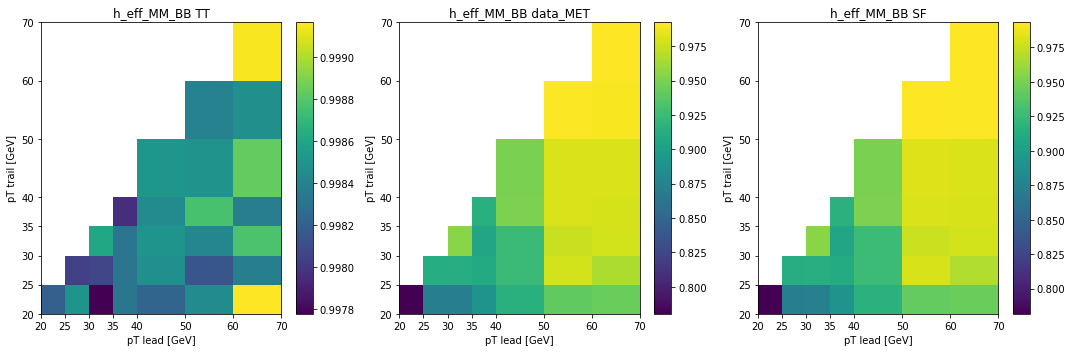

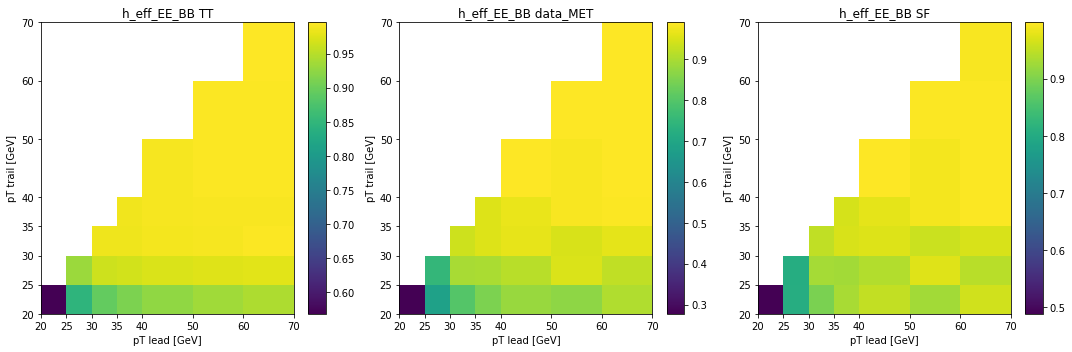

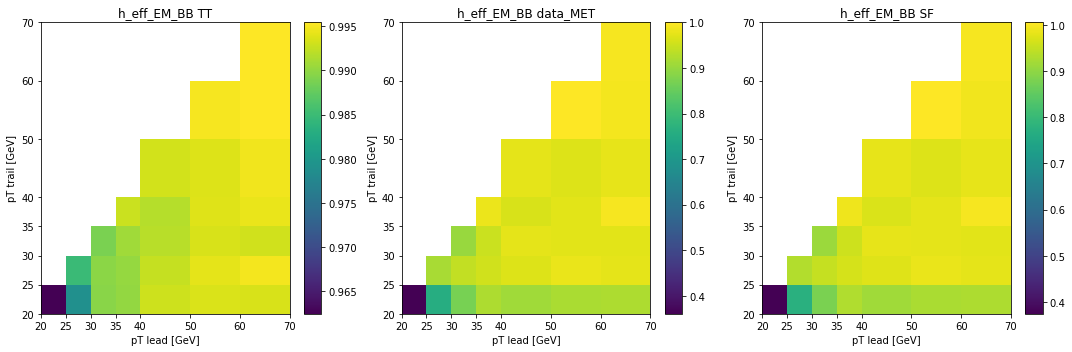

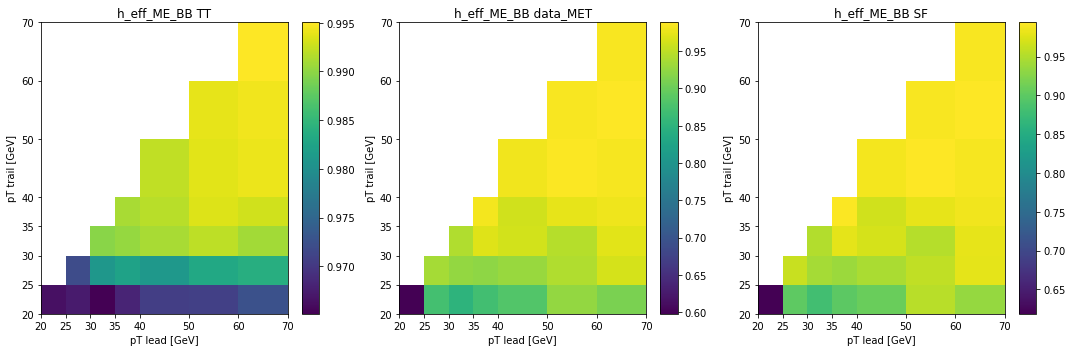

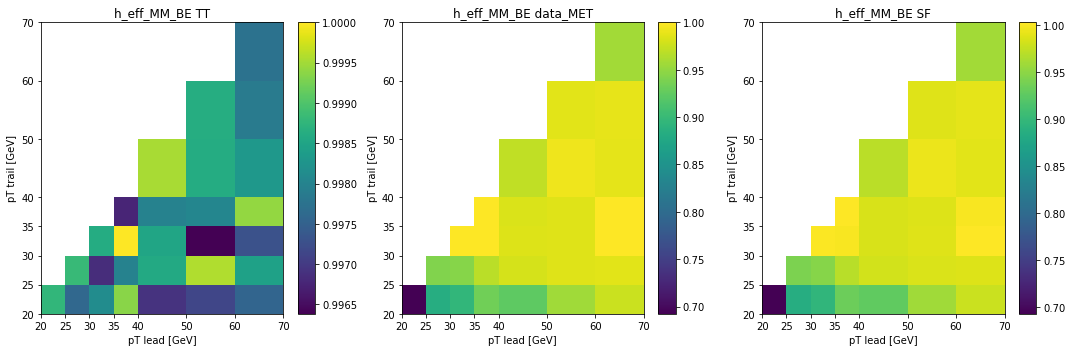

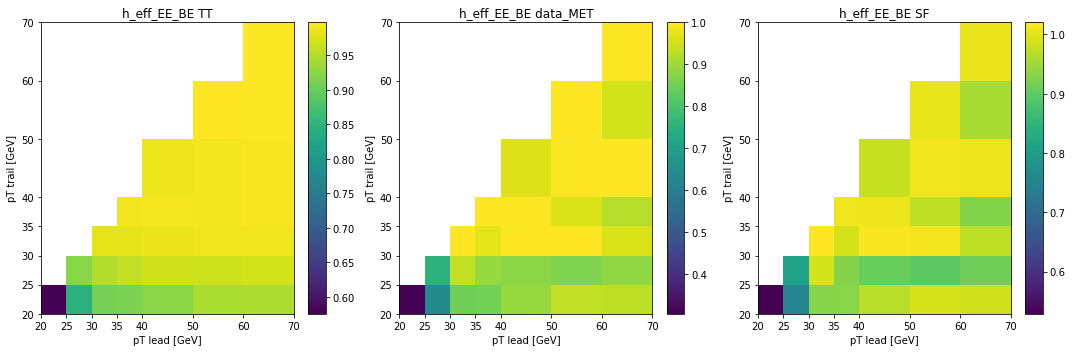

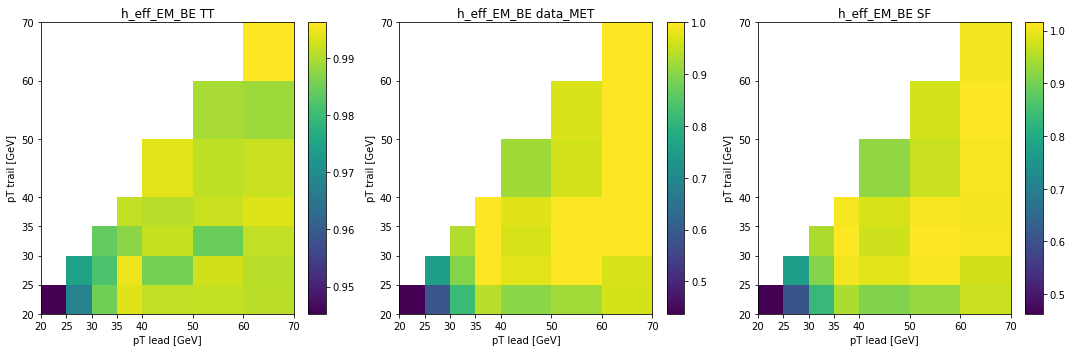

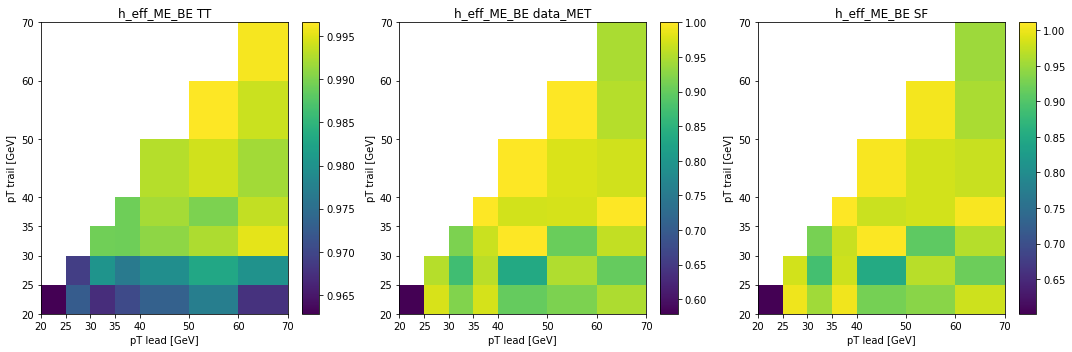

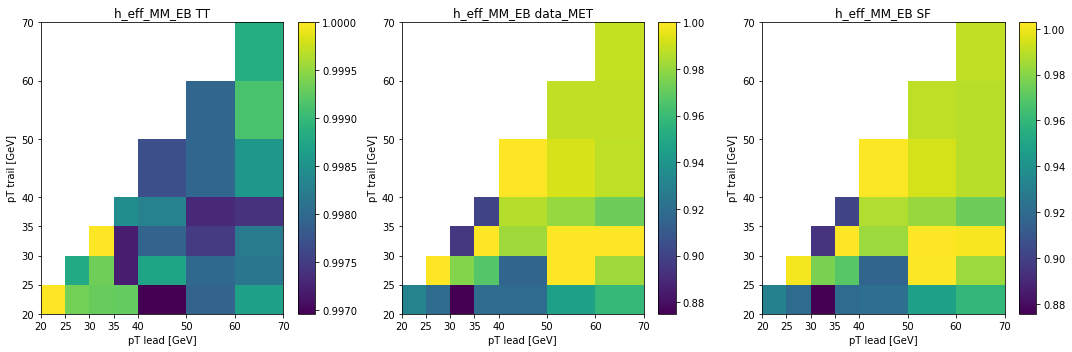

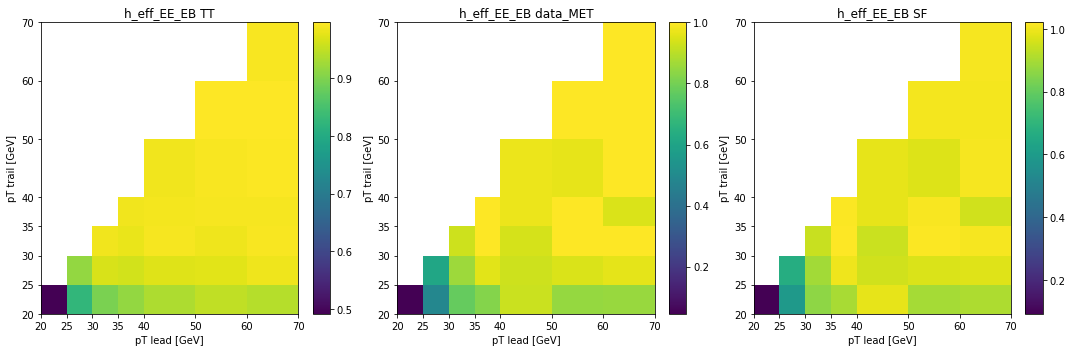

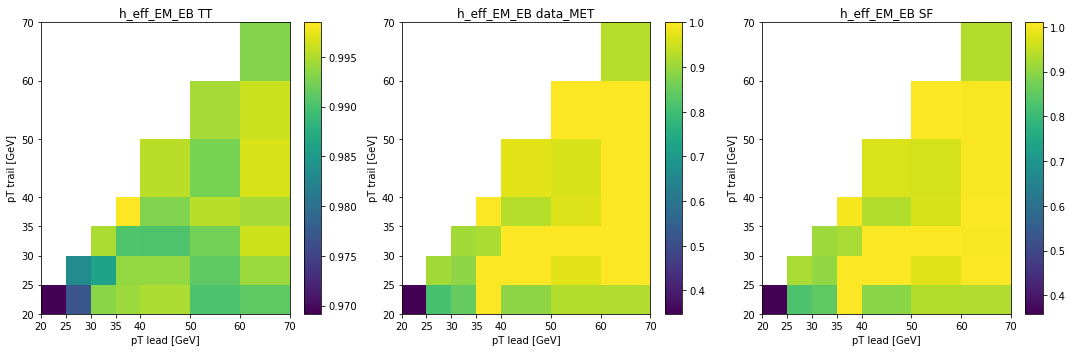

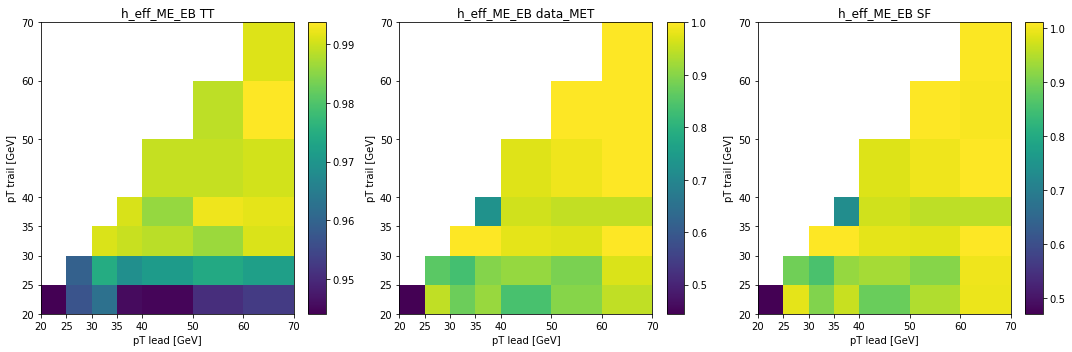

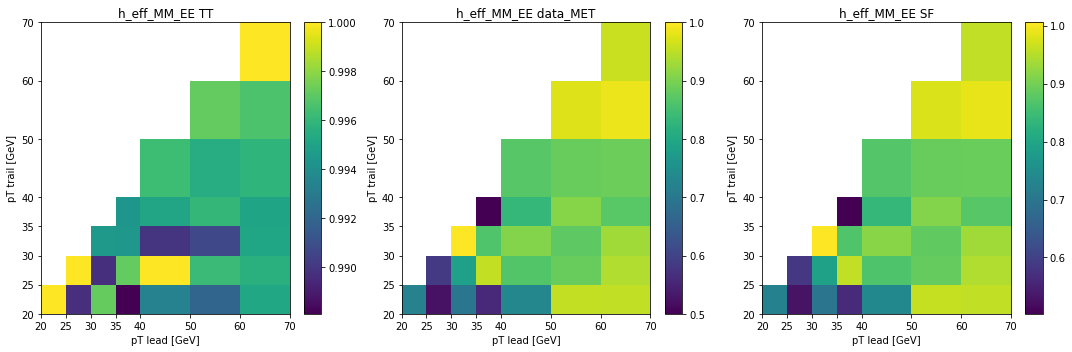

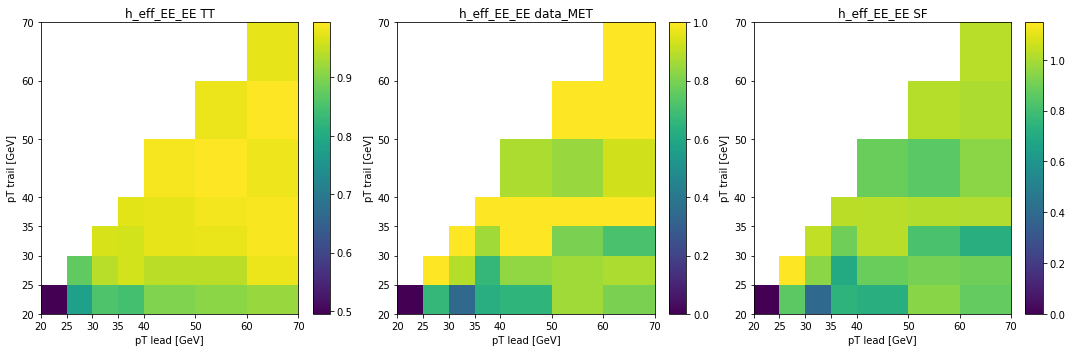

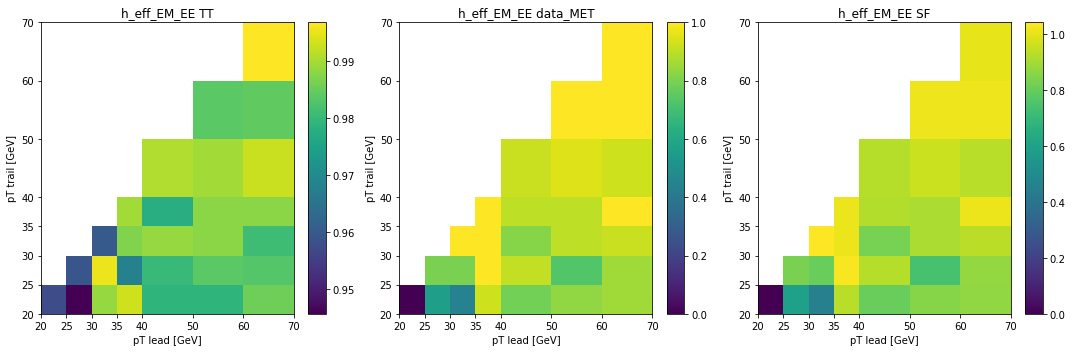

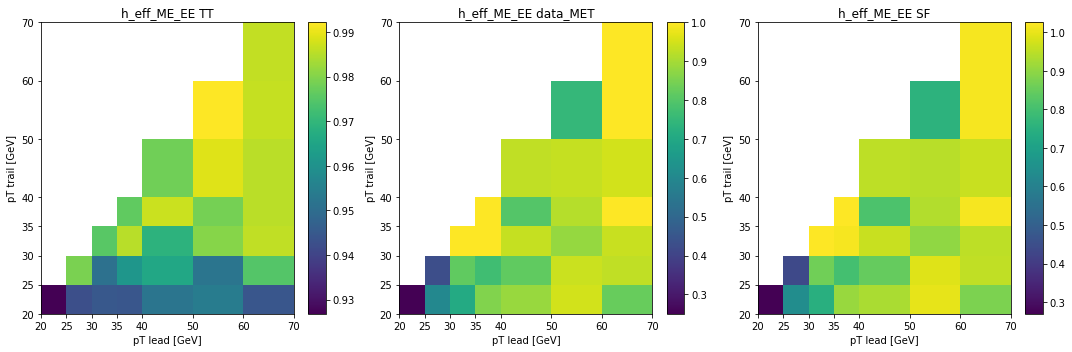

In [11]:
for k, v in dict_eff.items():
    plt.figure(figsize=(15,5))
    # MC
    proc_MC = 'TT'
    plt.subplot(1, 3, 1)
    v[proc_MC].plot2d()
    plt.title(k+' '+proc_MC)
    # data
    plt.subplot(1, 3, 2)
    proc_Data = 'data_MET'
    v[proc_Data].plot2d()
    plt.title(k+' '+proc_Data)
    # SF
    plt.subplot(1, 3, 3)
    h_SF = v[proc_Data] / v[proc_MC]
    h_SF.plot2d()
    plt.title(k+' SF')
    # space between 2 plots
    plt.tight_layout()
    
    cat_lep, cat_det = k.split('_')[-2:]
    fig_name = cat_lep.lower() + cat_det.lower() + '.pdf'
    # print(cat_lep.lower()+cat_det.lower())
    plt.savefig('plots/' + fig_name)

In [11]:
f_out = uproot.recreate(f"TrigEff_{year}.root")

for h_name, histo in output.items():
    # print(h_name, type(histo['data_MET']))
    f_out[h_name+'_TT'] = histo['TT'].sum('dataset').to_hist()
    f_out[h_name+'_data_MET'] = histo['data_MET'].sum('dataset').to_hist()
    
f_out.close()